In [38]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image
from torchvision import transforms


In [39]:
class Image_dataset(Dataset):
    """Dataset wrapping tensors."""
    
    def __init__(self, tensors, labels):
        """
        Args:
            tensors (list of Tensor): A list of PyTorch tensors representing your data.
            labels (list, optional): A list of labels for the data.
        """
        self.tensors = tensors
        self.labels = labels
    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, index):
        tensor = self.tensors[index]
        
        if self.labels is not None:
            return tensor, self.labels[index]
        return tensor

In [62]:
folders = ["data/", "data2/", "data3/"]
transform = transforms.ToTensor()
images = []
labels = []
for i in folders:
    for j in os.listdir(i):
        if "png" in j:
            image = Image.open(i + j)

            with open(i + j.split(".png")[0] + "_catalog.pkl", "rb") as f:
                info = pickle.load(f)
            labels.append(info)
            tensor_image = transform(image)
            images.append(tensor_image)

KeyboardInterrupt: 

In [46]:
dataset = Image_dataset(images, labels)

In [47]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)


In [58]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        # Define layers of the network
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=3415104, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=6)

    def forward(self, x):
        # Apply Convolutional layers followed by BatchNorm, ReLU and MaxPool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the tensor for passing it to fully connected layers
        x = x.view(x.size(0), -1)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [94]:
# Should be (u, sigma, b1, a1, b2, a2)

In [104]:

def log_normal_loss(mu, sigma, target):
    loss = 0
    for i in range(len(mu)):
        loss += torch.log(torch.tensor(target[i])) + torch.log(sigma[i]) + torch.log(torch.sqrt(torch.tensor(2*torch.pi))) + (torch.log(torch.tensor(target[i])) - mu[i])**2/(2*(sigma[i])**2)
        print(loss)
    return loss

def uniform_loss(a,b, observation):
    loss = 0
    for i in range(len(observation)):
        if observation[i] >= a[i] and observation[i] <= b[i]:
            loss += torch.log(b[i] - a[i])
        else:
            return torch.inf

In [68]:
import random

In [108]:
device = torch.device("cpu")
batch_size = 8
simplenet = SimpleNet().to(device)
optimizer = torch.optim.Adam(simplenet.parameters(), lr=0.001)
num_epochs = 20001
losses = []

for epoch in range(num_epochs):
    data = list(zip(images, labels))
    input, output = zip(*random.sample(data, 8))
    #Forward pass
    nn_output = simplenet(torch.stack(input))
    # Slicing the output to get means and raw variances
    raw_mu_hat_mu, raw_sigma_hat_sigma = nn_output[:, 0], nn_output[:, 1]
    raw_mu_hat_a1, raw_sigma_hat_b1 = nn_output[:, 2], nn_output[:, 3]
    raw_mu_hat_a2, raw_sigma_hat_b2 = nn_output[:, 4], nn_output[:, 5]

    # mu_hat_f = F.softplus(raw_mu_hat_f)
    # mu_hat_l1 = F.softplus(raw_mu_hat_l1)
    # mu_hat_l2 = F.softplus(raw_mu_hat_l2)
    # sigma_hat_f = F.softplus(raw_sigma_hat_f)
    # sigma_hat_l1 = F.softplus(raw_sigma_hat_l1)
    # sigma_hat_l2 = F.softplus(raw_sigma_hat_l2)

    target_mass = [entry['mass'] for entry in output]
    target_x = [entry['coordinate'][0] for entry in output]
    target_y = [entry['coordinate'][1] for entry in output]


    # Forward pass: Compute predicted outputs by passing data to the model

    # Compute each component of the loss
    loss1 = log_normal_loss(raw_mu_hat_mu, raw_sigma_hat_sigma, target_mass)
    loss2 = uniform_loss(raw_mu_hat_a1, raw_sigma_hat_b1, target_x)
    loss3 = uniform_loss(raw_mu_hat_a2, raw_sigma_hat_b2, target_y)
    # Sum the losses
    total_loss = loss1 + loss2 + loss3
        # Backward pass: Compute gradient of the total loss with respect to model parameters
    total_loss.backward()
    losses.append(total_loss.detach().cpu().numpy())
        # Update model parameters
    optimizer.step()
        # Zero the gradients
    optimizer.zero_grad()
plt.plot(losses)

tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)


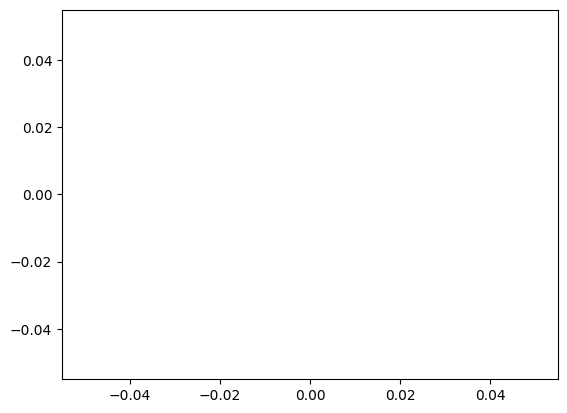

In [99]:
plt.plot(losses)

In [89]:
nn_output

tensor([[ 0.0220, -0.0537, -0.0924,  0.0176, -0.0529, -0.0707],
        [ 0.0222, -0.0556, -0.0917,  0.0146, -0.0525, -0.0729],
        [ 0.0212, -0.0529, -0.0930,  0.0157, -0.0553, -0.0749],
        [ 0.0239, -0.0534, -0.0917,  0.0156, -0.0513, -0.0721],
        [ 0.0251, -0.0531, -0.0942,  0.0159, -0.0566, -0.0727],
        [ 0.0216, -0.0519, -0.0944,  0.0165, -0.0538, -0.0717],
        [ 0.0217, -0.0543, -0.0906,  0.0162, -0.0558, -0.0727],
        [ 0.0224, -0.0510, -0.0931,  0.0158, -0.0556, -0.0732]],
       grad_fn=<AddmmBackward0>)

In [86]:
torch.stack(input, dim = 0).shape

torch.Size([8, 4, 924, 924])

In [81]:
input[0].shape

torch.Size([4, 924, 924])